Feature Engineering for Fraud Detection

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from scipy import sparse



In [5]:

df = pd.read_csv("../data/raw/fraud_data.csv")
# Ensure datetime columns are correct
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# Sort by user and purchase_time
df = df.sort_values(['user_id','purchase_time'])

# 1.Total transactions per user
df['user_transaction_count'] = df.groupby('user_id')['purchase_time'].transform('count')

# 2.Transactions in last 24 hours per user (rolling window)
def rolling_transactions(group):
    group = group.copy()
    group['transactions_last_24h'] = group.rolling('24h', on='purchase_time')['user_id'].count()
    return group

df = df.groupby('user_id', group_keys=False).apply(rolling_transactions)

# 3.Time since last transaction per user (in minutes)
df['time_since_last_transaction'] = df.groupby('user_id')['purchase_time'].diff().dt.total_seconds() / 60

# 4.Hour of day
df['hour_of_day'] = df['purchase_time'].dt.hour

# 5.Day of week
df['day_of_week'] = df['purchase_time'].dt.dayofweek  # 0=Monday, 6=Sunday

# 6.Time since signup (in hours)
df['time_since_signup'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600

# Quick check
df.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_49180\2115103610.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('user_id', group_keys=False).apply(rolling_transactions)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,user_transaction_count,transactions_last_24h,time_since_last_transaction,hour_of_day,day_of_week,time_since_signup
116708,2,2015-01-11 03:47:13,2015-02-21 10:03:37,54,FGBQNDNBETFJJ,SEO,Chrome,F,25,8.802175e+08,0,1,1.0,NaN,10,5,990.273333
15108,4,2015-06-02 16:40:57,2015-09-26 21:32:16,41,MKFUIVOHLJBYN,Direct,Safari,F,38,2.785906e+09,0,1,1.0,NaN,21,5,2788.855278
46047,8,2015-05-28 07:53:06,2015-08-13 11:53:07,47,SCQGQALXBUQZJ,SEO,Chrome,M,25,3.560567e+08,0,1,1.0,NaN,11,3,1852.000278
67650,9,2015-05-16 15:58:32,2015-05-20 23:06:42,62,IEZOHXPZBIRTE,SEO,FireFox,M,21,7.591047e+08,0,1,1.0,NaN,23,2,103.136111
109067,12,2015-01-10 06:25:12,2015-03-04 20:56:37,35,MSNWCFEHKTIOY,Ads,Safari,M,19,2.985180e+09,0,1,1.0,NaN,20,2,1286.523611


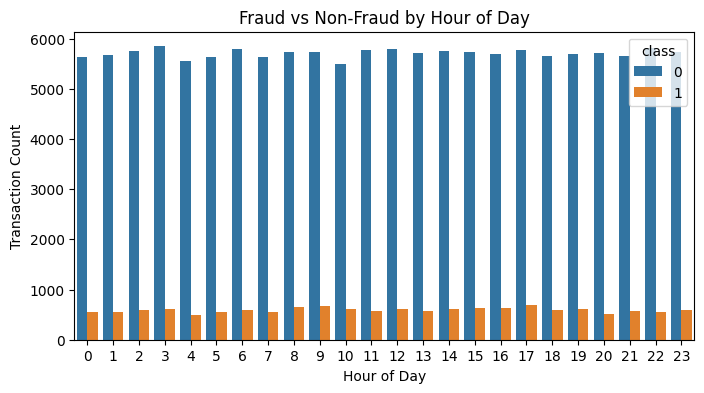

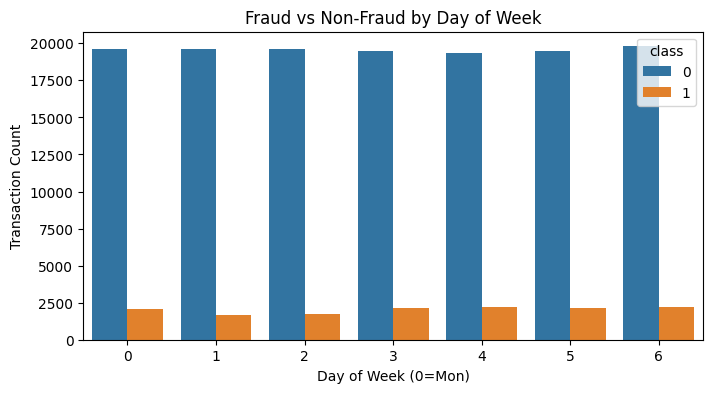

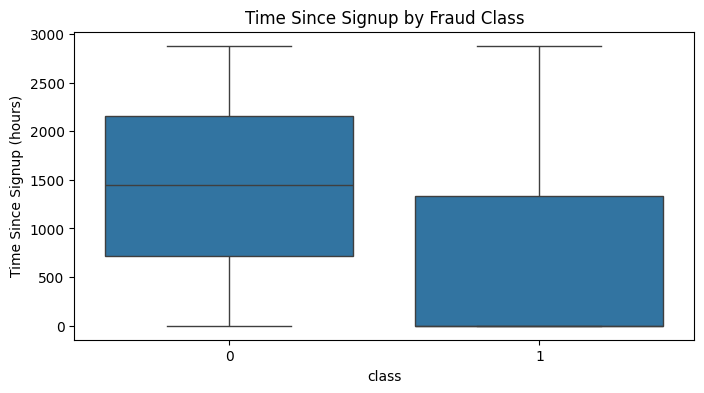

In [6]:
#Visualize Time-Based Features
#hour of day
plt.figure(figsize=(8,4))
sns.countplot(x='hour_of_day', hue='class', data=df)
plt.title('Fraud vs Non-Fraud by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Transaction Count')
plt.show()
#day of week
plt.figure(figsize=(8,4))
sns.countplot(x='day_of_week', hue='class', data=df)
plt.title('Fraud vs Non-Fraud by Day of Week')
plt.xlabel('Day of Week (0=Mon)')
plt.ylabel('Transaction Count')
plt.show()
#time since signup
plt.figure(figsize=(8,4))
sns.boxplot(x='class', y='time_since_signup', data=df)
plt.title('Time Since Signup by Fraud Class')
plt.ylabel('Time Since Signup (hours)')
plt.show()


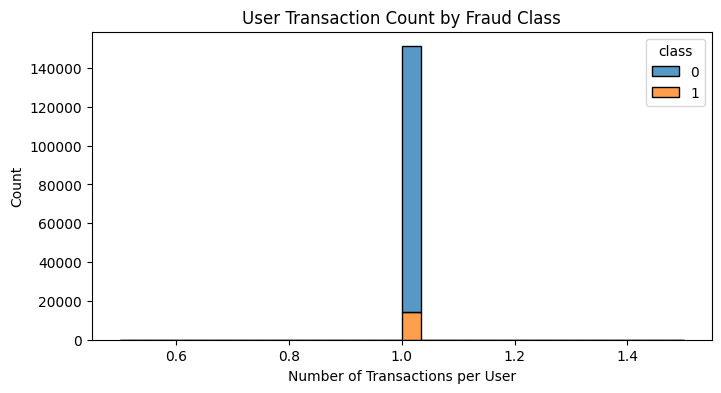

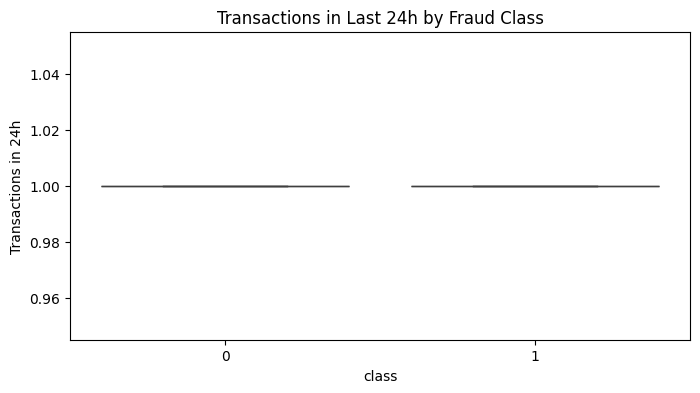

In [7]:
#Visualize Transaction Frequency / Velocity
#User Transaction Count
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='user_transaction_count', bins=30, hue='class', multiple='stack')
plt.title('User Transaction Count by Fraud Class')
plt.xlabel('Number of Transactions per User')
plt.ylabel('Count')
plt.show()
#Transactions in Last 24 Hours
plt.figure(figsize=(8,4))
sns.boxplot(x='class', y='transactions_last_24h', data=df)
plt.title('Transactions in Last 24h by Fraud Class')
plt.ylabel('Transactions in 24h')
plt.show()



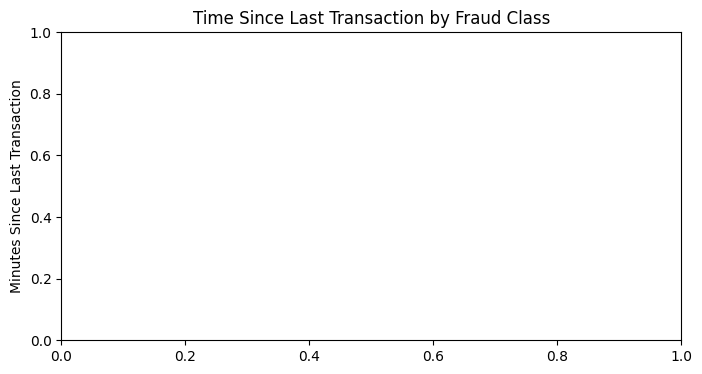

In [8]:
#Time Since Last Transaction
plt.figure(figsize=(8,4))
sns.boxplot(x='class', y='time_since_last_transaction', data=df.dropna(subset=['time_since_last_transaction']))
plt.title('Time Since Last Transaction by Fraud Class')
plt.ylabel('Minutes Since Last Transaction')
plt.show()



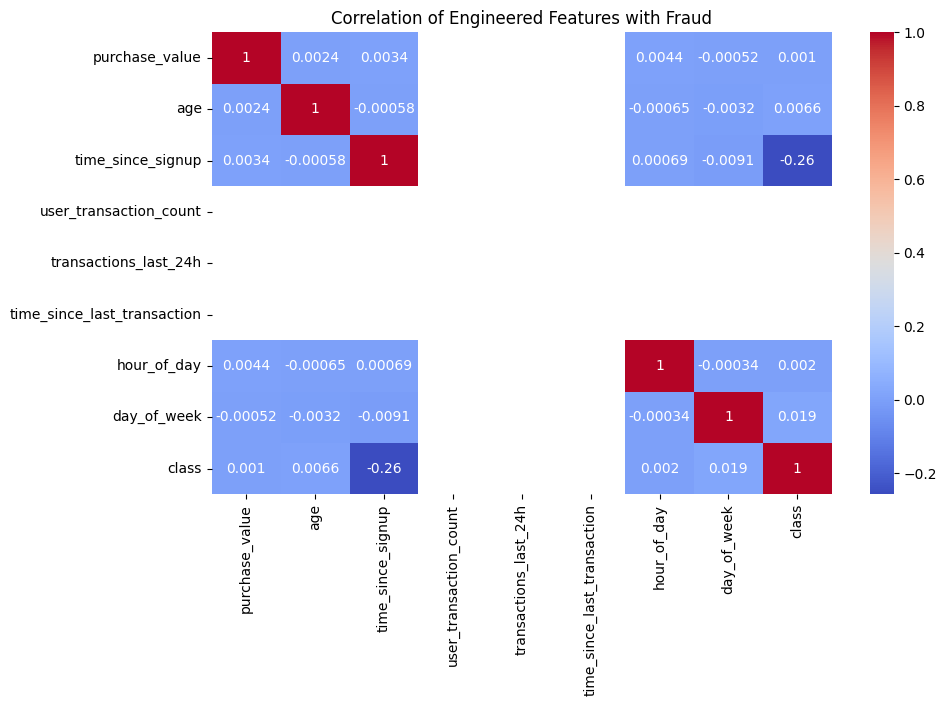

In [9]:
#Correlation Heatmap with Target

num_features = ['purchase_value','age','time_since_signup','user_transaction_count',
                'transactions_last_24h','time_since_last_transaction','hour_of_day','day_of_week']

plt.figure(figsize=(10,6))
sns.heatmap(df[num_features + ['class']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of Engineered Features with Fraud')
plt.show()


Data Transformation

In [10]:
#Scale Numerical Features
# Numerical features
num_features = ['purchase_value','age','user_transaction_count',
                'transactions_last_24h','time_since_last_transaction',
                'hour_of_day','day_of_week','time_since_signup']

# Create scaler
scaler = StandardScaler()

# Fit and transform numerical features
X_num_scaled = scaler.fit_transform(df[num_features])

# Optional: convert back to DataFrame
X_num_scaled_df = pd.DataFrame(X_num_scaled, columns=num_features)
X_num_scaled_df.head()


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,purchase_value,age,user_transaction_count,transactions_last_24h,time_since_last_transaction,hour_of_day,day_of_week,time_since_signup
0,0.931338,-0.944649,0.0,0.0,NaN,-0.220124,0.991020,-0.437279
1,0.221836,0.563874,0.0,0.0,NaN,1.371208,0.991020,1.633857
2,0.549298,-0.944649,0.0,0.0,NaN,-0.075457,-0.005891,0.555032
3,1.367955,-1.408809,0.0,0.0,NaN,1.660541,-0.504347,-1.458852
4,-0.105627,-1.640890,0.0,0.0,NaN,1.226541,-0.504347,-0.096136


In [11]:
#Encode Categorical Features
# Categorical features
cat_features = ['device_id','source','browser','sex']

# Create encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

# Fit and transform categorical features
X_cat_encoded = encoder.fit_transform(df[cat_features])

# Get column names
cat_columns = encoder.get_feature_names_out(cat_features)

X_num_sparse = sparse.csr_matrix(X_num_scaled)

# Combine numerical and categorical sparse matrices
X_transformed_sparse = hstack([X_num_sparse, X_cat_encoded])

print(X_transformed_sparse.shape)  # huge but memory efficient



(151112, 137974)


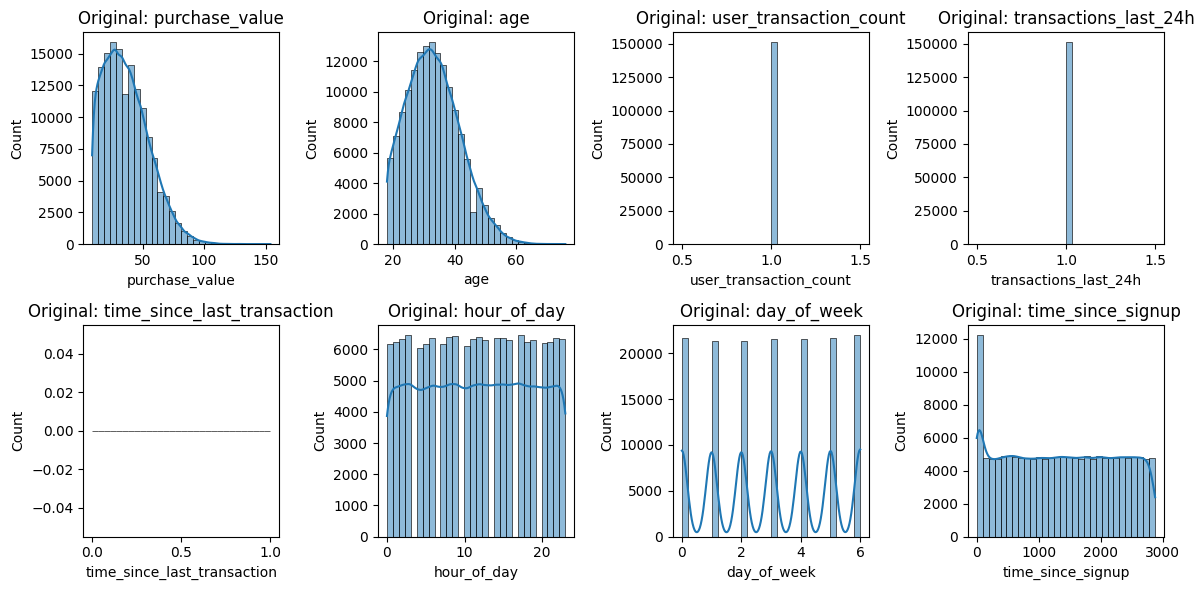

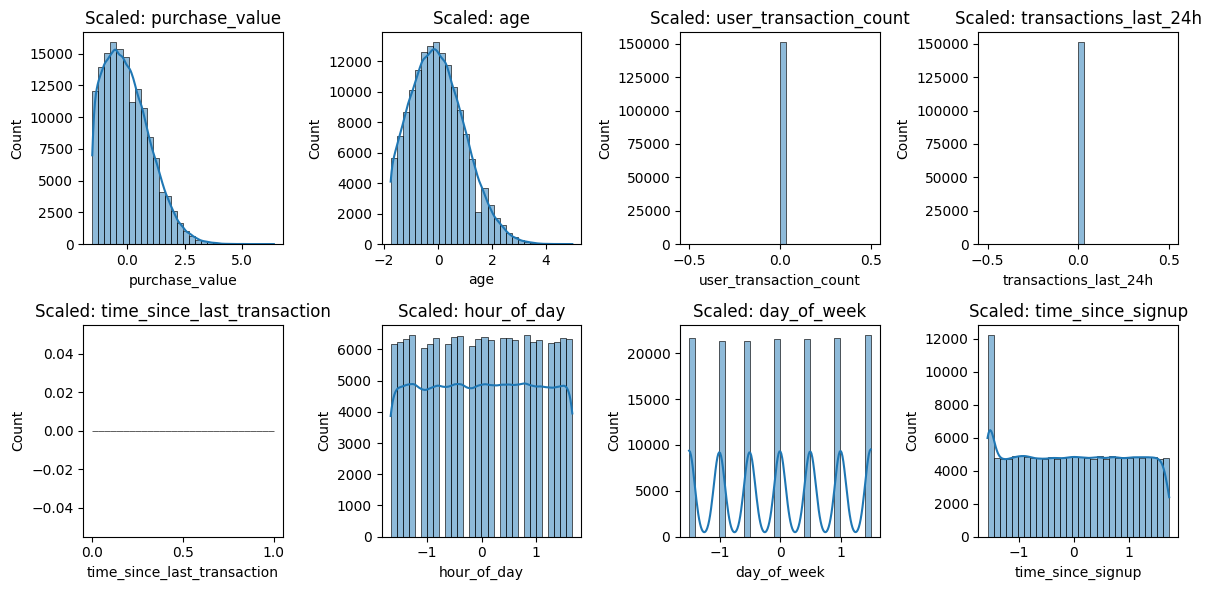

In [12]:
#Visualize Scaled Numerical Features
num_features = ['purchase_value','age','user_transaction_count',
                'transactions_last_24h','time_since_last_transaction',
                'hour_of_day','day_of_week','time_since_signup']

# Original data
plt.figure(figsize=(12,6))
for i, col in enumerate(num_features):
    plt.subplot(2,4,i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Original: {col}')
plt.tight_layout()
plt.show()

# Scaled data
plt.figure(figsize=(12,6))
for i, col in enumerate(num_features):
    plt.subplot(2,4,i+1)
    sns.histplot(X_num_scaled_df[col], kde=True, bins=30)
    plt.title(f'Scaled: {col}')
plt.tight_layout()
plt.show()


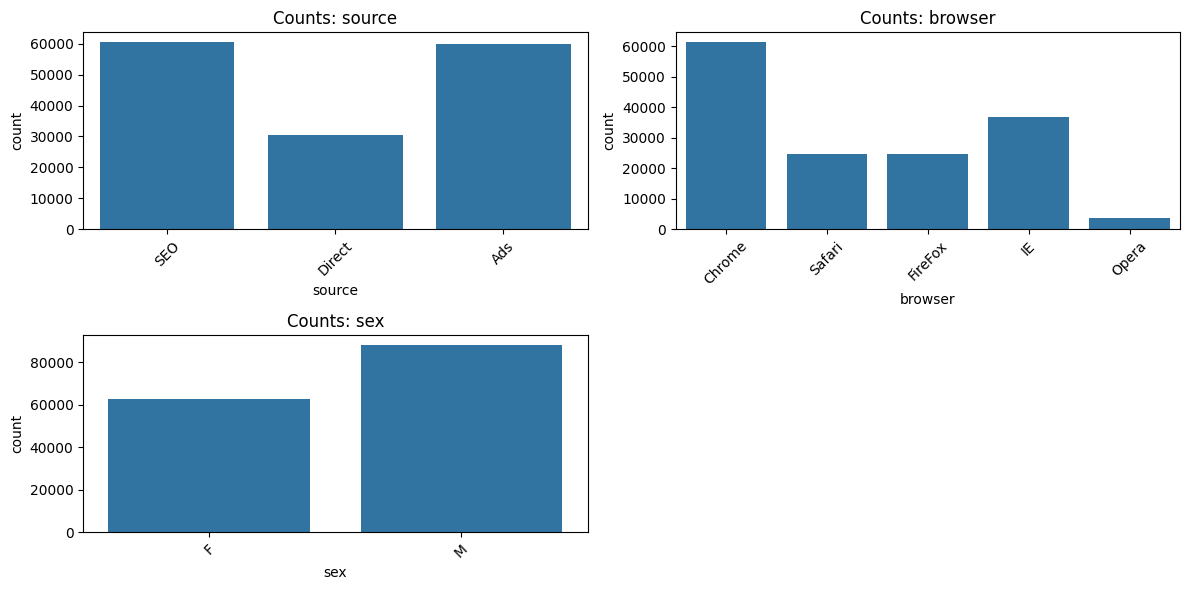

In [13]:
#Visualize Categorical Encoding
cat_features = ['source','browser','sex']

plt.figure(figsize=(12,6))
for i, col in enumerate(cat_features):
    plt.subplot(2,2,i+1)
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=45)
    plt.title(f'Counts: {col}')
plt.tight_layout()
plt.show()


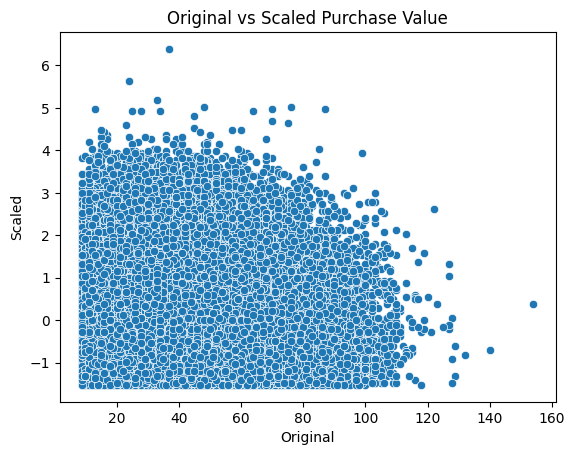

In [14]:
sns.scatterplot(x=df['purchase_value'], y=X_num_scaled_df['purchase_value'])
plt.title('Original vs Scaled Purchase Value')
plt.xlabel('Original')
plt.ylabel('Scaled')
plt.show()



Handle Class Imbalance

In [15]:
#Train-Test Split
from sklearn.model_selection import train_test_split

# Assuming 'class' is your target variable
y = df['class']

# Split sparse matrix into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed_sparse, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (120889, 137974)
Test set shape: (30223, 137974)


Before resampling:
 class
0    109568
1     11321
Name: count, dtype: int64


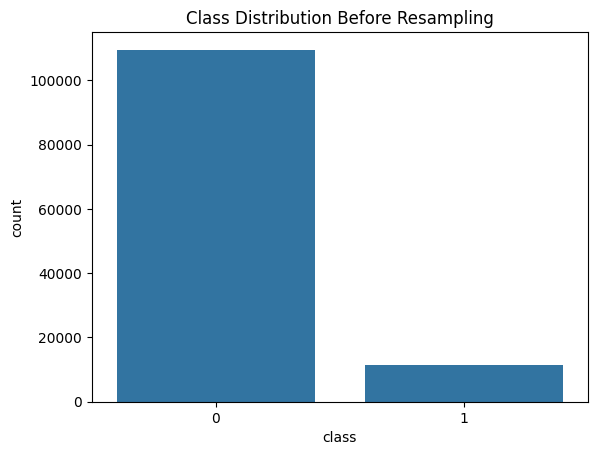

In [16]:
print("Before resampling:\n", y_train.value_counts())

sns.countplot(x=y_train)
plt.title("Class Distribution Before Resampling")
plt.show()


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['time_since_last_transaction']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Before SMOTE:
class
0    109568
1     11321
Name: count, dtype: int64


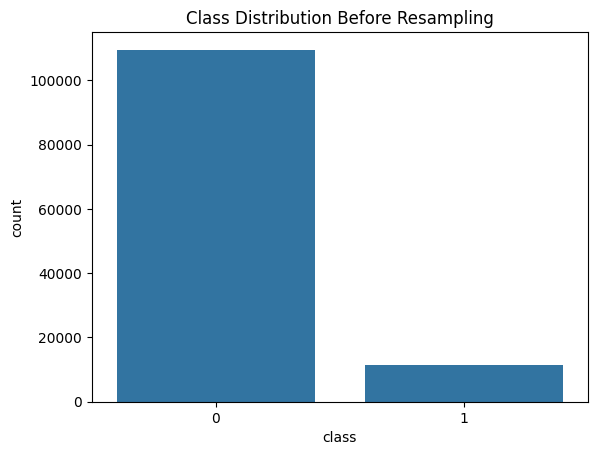

Before SMOTE:
 class
0    109568
1     11321
Name: count, dtype: int64
After SMOTE:
 class
0    109568
1    109568
Name: count, dtype: int64


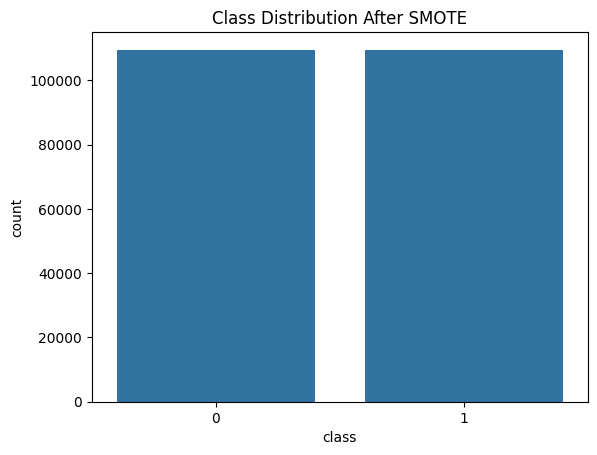

In [22]:
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Impute missing values
num_imputer = SimpleImputer(strategy='median')
X_num_imputed = num_imputer.fit_transform(X_num_scaled_df)  # scaled numerical features

cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat_imputed = cat_imputer.fit_transform(df[cat_features])


# 2. Encode categorical features

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat_encoded = encoder.fit_transform(X_cat_imputed)


# 3. Combine numerical + categorical

X_num_sparse = sparse.csr_matrix(X_num_imputed)
X_combined = sparse.hstack([X_num_sparse, X_cat_encoded])


# 4. Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, df['class'], test_size=0.2, random_state=42, stratify=df['class']
)

# 5. Class distribution after resampling
print("Before SMOTE:")
print(y_train.value_counts())

sns.countplot(x=y_train)
plt.title("Class Distribution Before Resampling")
plt.show()


# 6. Apply SMOTE on training data only

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


# 7. Class distribution after resampling

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_res.value_counts())

sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.show()


1️. Choice of Technique
Why SMOTE?

Fraud detection datasets are highly imbalanced: the number of legitimate transactions is much higher than fraudulent ones.

Using standard classifiers without addressing imbalance may bias the model towards the majority class, resulting in poor fraud detection.

SMOTE (Synthetic Minority Oversampling Technique) generates synthetic samples of the minority class instead of just duplicating existing ones.

Preserves majority class data.

Provides enough minority examples for the model to learn patterns.

Reduces risk of overfitting compared to random oversampling.

Applied only to training data, ensuring test data remains realistic for unbiased evaluation.